## Import the libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

## Import Train Feature Enginering and Selected Features CSV files

In [2]:
df = pd.read_csv('Train Feature Engineering.csv')
selected_features = pd.read_csv('selected_features.csv')
selected_features = selected_features['0'].tolist()

## Define the X, Y and split it into Training and Test dataset

In [3]:
y = df['satisfaction']
X = df[selected_features]

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=41, test_size=0.2)

## Model Comparassion

###### Model selection with metrics, the metrics that I use is accuracy and precission in model selection. Precission is choose cause I want to minimize the False Positive (not satisfied data classify as satisfied) to get the worst case scenario, so the Airline can do maximum improve in the service

In [6]:
def model_selection(X_train, y_train, X_test, y_test, models):
    
    from sklearn.metrics import accuracy_score, precision_score
    
    accuracy_result = []
    precission_result = []
    str_models = []
    
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        precission = precision_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)       
        accuracy_result.append(accuracy)
        precission_result.append(precission)  
        str_models.append(str(model))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

    ax1.plot(accuracy_result)
    ax1.set_ylabel('accuracy_score')

    ax2.plot(str_models,precission_result)
    ax2.set_ylabel('precission_result')
    ax2.set_xticklabels(str_models, rotation=90)
    plt.tight_layout()
    
    return pd.DataFrame({'models':models, 'accuracy':accuracy_result, 'precission':precission_result}) 

In [5]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

C:\Users\User\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


,models,accuracy,precission
0,LogisticRegression(),0.885087,0.869842
1,RidgeClassifier(alpha=0.005),0.880083,0.860570
2,LinearSVC(),0.884991,0.870149
3,SVC(),0.943843,0.958689
4,KNeighborsClassifier(),0.931187,0.950513
5,RadiusNeighborsClassifier(),0.903662,0.929150
6,DecisionTreeClassifier(),0.937587,0.923806
7,"(DecisionTreeClassifier(max_features='auto', r...",0.957221,0.969836
8,"(DecisionTreeClassifier(max_depth=1, random_st...",0.909148,0.901179
9,MLPClassifier(),0.945335,0.951157


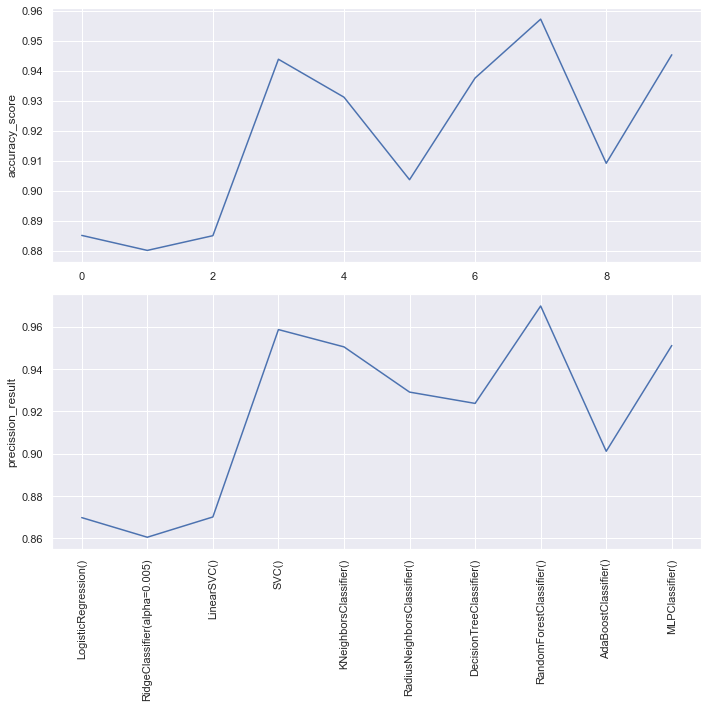

In [16]:
models = [LogisticRegression(), RidgeClassifier(alpha=0.005), LinearSVC(), SVC(), KNeighborsClassifier(),
          RadiusNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(),
          AdaBoostClassifier(), MLPClassifier()]

model_selection(X_train, y_train, X_test, y_test, models)

## Best Classsifier Model

In [6]:
rf = RandomForestClassifier()
svc = SVC()

## Random Forest

### Confusion Matrix 

In [8]:
def confusion(X_train, y_train, X_test, y_test, model):
    from sklearn.metrics import confusion_matrix
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    confu_score = confusion_matrix(y_pred, y_test, labels=[1,0])
    return pd.DataFrame(confu_score, columns=['Actual Postive', 'Actual Negative'], 
                        index=['Predicted Positive', 'Predicted Negative'])

In [15]:
confusion(X_train, y_train, X_test, y_test, rf)

,Actual Postive,Actual Negative
Predicted Positive,8256,253
Predicted Negative,639,11633


###### The Random Forest have better performance based on the confusion matrix, its showed by the the smaller false positive

### ROC_AUC 

In [9]:
def ROC_AUC_test(X_train, y_train, X_test, y_test, model):
    from sklearn.metrics import roc_auc_score, roc_curve
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    y_pred = y_pred[:,1]
    AUC = roc_auc_score(y_test, y_pred)
    tpr, fpr, _ = roc_curve(y_test, y_pred)
    print('AUC: ' + str(AUC))
    plt.plot(tpr, fpr)
    plt.title('ROC performance for ' + str(model))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

AUC: 0.9920089784941204


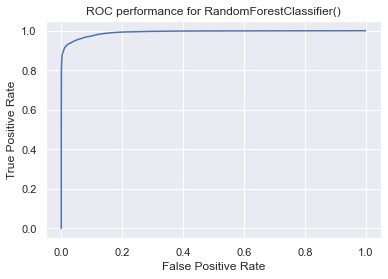

In [33]:
ROC_AUC_test(X_train, y_train, X_test, y_test, rf)

### Overfit and underfit check

In [10]:
def fit_check(model, kfolds):
    
    from sklearn.model_selection import KFold
    from sklearn.metrics import precision_score
    
    kf = KFold(n_splits=kfolds)
    list_training_error = []
    list_testing_error = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_train_data_pred = model.predict(X_train)
        y_test_data_pred = model.predict(X_test)
        fold_training_error = precision_score(y_train, y_train_data_pred)
        fold_testing_error = precision_score(y_test, y_test_data_pred)
        list_training_error.append(fold_training_error)
        list_testing_error.append(fold_testing_error)
    
    figsize=(5,5)
    plt.plot(range(1, kf.get_n_splits() + 1), np.array(list_training_error).ravel(), 'o-', label = 'training')
    plt.plot(range(1, kf.get_n_splits() + 1), np.array(list_testing_error).ravel(), 'o-', label = 'testing')
    plt.xlabel('number of fold')
    plt.ylabel('Precision')
    plt.title('Precision across folds')
    plt.legend()
    plt.tight_layout()
    plt.show()

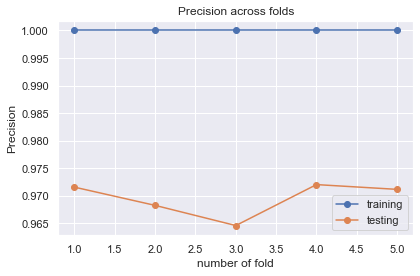

In [40]:
fit_check(rf, 5)

###### the overfit and underfit check showed that the model have an overfit indication cause the precision in training have better performance than precision in test set

### Hyperparameter Tuning in best model

####  Tuning using GridSearchCV per parameters

In [11]:
def tuning_param(X, y, model, parameters):
    
    from sklearn.model_selection import GridSearchCV   
        
    scores = []
   
    fig, axs = plt.subplots(len(parameters))
    k = 0   
    for parameter in parameters:
        
        clf = GridSearchCV(estimator = model, param_grid = parameter, cv=3, scoring='precision', n_jobs=-1)
        clf.fit(X, y)
        

        for name_param, val_param in parameter.items():
            
            grid_mean_scores = clf.cv_results_['mean_test_score']

            if len(parameters) == 1:
               axs.plot(val_param, grid_mean_scores)
               axs.set_xlabel(name_param)
               axs.set_ylabel('Precision') 
            
            else:
                axs[k].plot(val_param, grid_mean_scores)
                axs[k].set_xlabel(name_param)
                axs[k].set_ylabel('Precision')
                
                k+=1
            
            
        scores.append({'parameter':name_param,
                       'best_Precision':clf.best_score_,
                       'best_value':clf.best_params_})
            
    plt.tight_layout()       
    return pd.DataFrame(scores, columns=['parameter', 'best_Precision', 'best_value'])

,parameter,best_Precision,best_value
0,n_estimators,0.967289,{'n_estimators': 300}


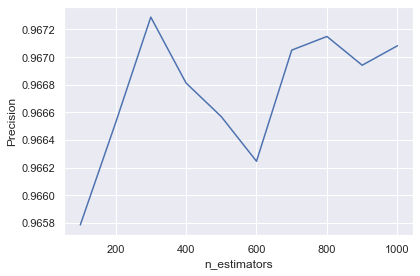

In [53]:
tuning_param(X_train, y_train, rf, [{'n_estimators': np.arange(100, 1010, 100)}])

,parameter,best_Precision,best_value
0,min_samples_split,0.967185,{'min_samples_split': 2}


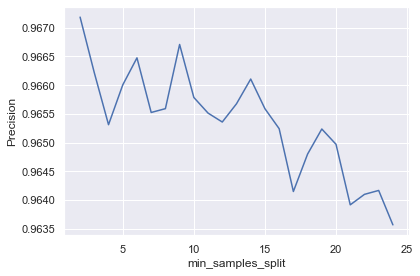

In [54]:
tuning_param(X_train, y_train, rf, [{'min_samples_split':np.arange(1, 25, 1)}])

,parameter,best_Precision,best_value
0,min_samples_leaf,0.966416,{'min_samples_leaf': 1}


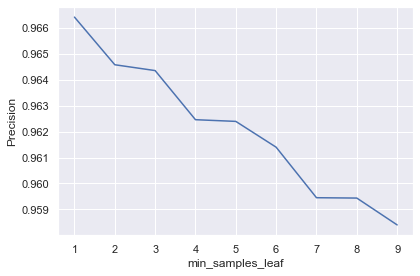

In [55]:
tuning_param(X_train, y_train, rf, [{'min_samples_leaf':np.arange(1, 10, 1)}])

,parameter,best_Precision,best_value
0,max_depth,0.966924,{'max_depth': 19}


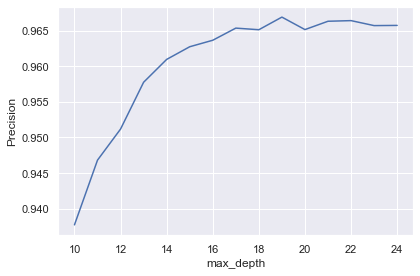

In [56]:
tuning_param(X_train, y_train, rf, [{'max_depth':np.arange(10,25, 1)}])

### Hyperparameter using RandomizedsearchCV

In [12]:
def model_randomCV(X, y, model, parameters):
    
    from sklearn.model_selection import RandomizedSearchCV
    
    randCV = RandomizedSearchCV(estimator=model, scoring='precision', param_distributions=parameters, n_jobs=-1, cv=3)
    
    randCV.fit(X, y)
   
    print('best_parameters: ' + str(randCV.best_params_))
    print('best_score: ' + str(randCV.best_score_))
    print('best_estimator: ' + str(randCV.best_estimator_))    
    
    return pd.DataFrame(randCV.cv_results_).sort_values(by='rank_test_score')

In [62]:
parameters = {'n_estimators': np.arange(290, 310, 5), 'max_features':['auto', 'sqrt', 'log2'], 'max_depth':np.arange(18,23, 1), 
             'min_samples_split':np.arange(3, 8, 1), 'criterion':['gini', 'entropy']}

model_randomCV(X_train, y_train, rf, parameters)

best_parameters: {'n_estimators': 295, 'min_samples_split': 3, 'max_features': 'sqrt', 'max_depth': 19, 'criterion': 'entropy'}
best_score: 0.9683368829908368
best_estimator: RandomForestClassifier(criterion='entropy', max_depth=19, max_features='sqrt',
                       min_samples_split=3, n_estimators=295)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_max_features,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,59.567000,0.335144,4.135335,0.173696,295,3,sqrt,19,entropy,"{'n_estimators': 295, 'min_samples_split': 3, ...",0.968631,0.966221,0.970158,0.968337,0.001621,1
1,64.507274,9.151691,4.565498,0.151912,295,3,sqrt,22,entropy,"{'n_estimators': 295, 'min_samples_split': 3, ...",0.967859,0.966724,0.970212,0.968265,0.001452,2
2,58.982875,1.297378,4.418999,0.130099,305,6,auto,20,entropy,"{'n_estimators': 305, 'min_samples_split': 6, ...",0.968055,0.965808,0.969705,0.967856,0.001597,3
3,56.130666,0.364109,4.193668,0.044977,295,5,auto,21,gini,"{'n_estimators': 295, 'min_samples_split': 5, ...",0.966491,0.965238,0.969084,0.966938,0.001601,4
6,55.918670,0.026234,4.014667,0.101465,290,4,sqrt,18,gini,"{'n_estimators': 290, 'min_samples_split': 4, ...",0.966134,0.964906,0.968986,0.966675,0.001709,5
0,76.895296,0.362028,5.184429,0.052139,305,7,sqrt,21,gini,"{'n_estimators': 305, 'min_samples_split': 7, ...",0.965714,0.965339,0.968075,0.966376,0.001211,6
8,54.932003,0.028894,3.882000,0.067363,290,6,log2,19,gini,"{'n_estimators': 290, 'min_samples_split': 6, ...",0.966549,0.964918,0.967616,0.966361,0.001109,7
4,59.084667,0.417676,4.108669,0.053326,305,6,sqrt,19,gini,"{'n_estimators': 305, 'min_samples_split': 6, ...",0.966808,0.963341,0.968815,0.966321,0.002261,8
7,57.538665,0.334213,4.211337,0.010875,300,4,auto,20,gini,"{'n_estimators': 300, 'min_samples_split': 4, ...",0.965887,0.964387,0.968601,0.966291,0.001744,9
9,50.524995,3.846431,3.302029,0.423798,290,4,log2,21,gini,"{'n_estimators': 290, 'min_samples_split': 4, ...",0.965708,0.964918,0.967725,0.966117,0.001182,10


###### The best random forest model got slightly better in precision score, which is 0.968

### Random Forest after Hyperparameter Tuning

In [38]:
rf_best = RandomForestClassifier(criterion='entropy', max_depth=19, max_features='sqrt',
                       min_samples_split=3, n_estimators=295)

In [41]:
confusion(X_train, y_train, X_test, y_test, rf_best)

,Actual Postive,Actual Negative
Predicted Positive,8248,245
Predicted Negative,647,11641


AUC: 0.9926604173033363


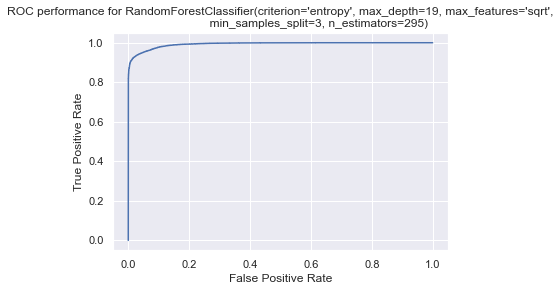

In [31]:
ROC_AUC_test(X_train, y_train, X_test, y_test, rf_best)

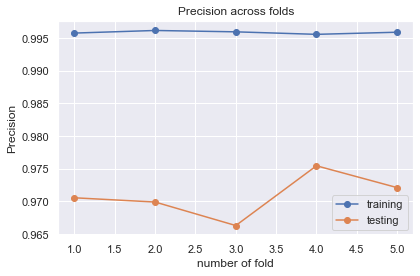

In [42]:
fit_check(rf_best, 5)

###### The fitting of Rnadom Forest after tuning shows that the overfit is slightly decrease, but it's not enough to dispute the overfitting indication in default Random Forest 

## Support Vector Classifier

In [56]:
confusion(X_train, y_train, X_test, y_test, svc)

,Actual Postive,Actual Negative
Predicted Positive,8076,348
Predicted Negative,819,11538


AUC: 0.9824903379935885


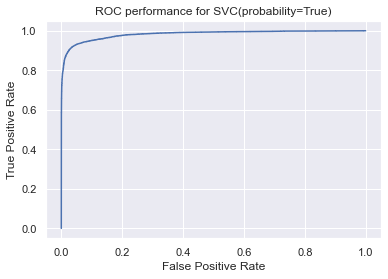

In [60]:
svc_prob_true = SVC(probability=True)

ROC_AUC_test(X_train, y_train, X_test, y_test, svc_prob_true)

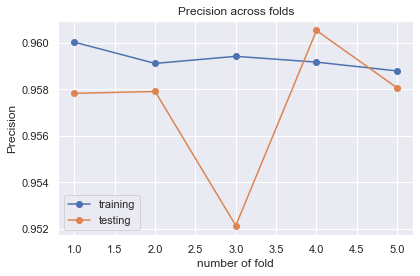

In [58]:
fit_check(svc, 5)

###### The SVC's performance(precision and ROC_AUC) is no better than Random Forest, but the fitiing perform better than Random Forest

### Hyperparameter Tuning

,parameter,best_Precision,best_value
0,C,0.963632,{'C': 10}


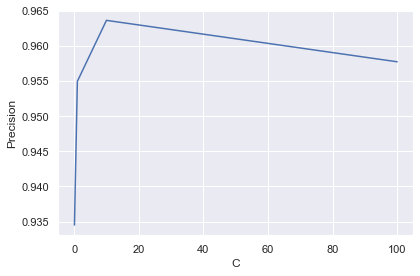

In [62]:
tuning_param(X_train, y_train, svc, [{'C': [0.1, 1, 10, 100]}])

,parameter,best_Precision,best_value
0,kernel,0.956055,{'kernel': 'poly'}


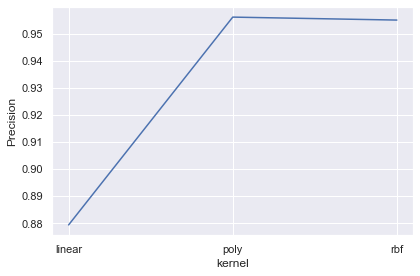

In [63]:
tuning_param(X_train, y_train, svc, [{'kernel': ['linear', 'poly', 'rbf']}])

,parameter,best_Precision,best_value
0,gamma,0.971289,{'gamma': 10}


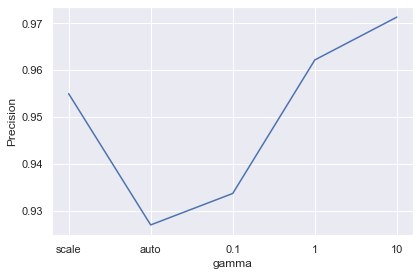

In [9]:
tuning_param(X_train, y_train, svc, [{'gamma': ['scale', 'auto', 0.1, 1, 10]}])

,parameter,best_Precision,best_value
0,kernel,0.956055,{'kernel': 'poly'}
1,degree,0.954960,{'degree': 1}


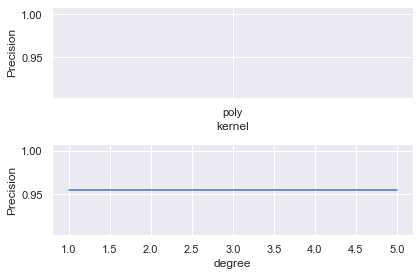

In [17]:
tuning_param(X_train, y_train, svc, [{'kernel': ['poly']}, {'degree':[1,2,3,4,5]}])

In [ ]:
parameters = {'C': [1, 10], 'kernel':['poly', 'rbf'], 'gamma':[1, 10]}

model_randomCV(X_train, y_train, svc, parameters)

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


###### Cause the cost time for tuning all parameters above using RandomizedSearchCV in SVC model, Iam just check the fitting and the performance of the new model based on result from GridSearchcv at each parameter 

## SVC after Hyperparameter

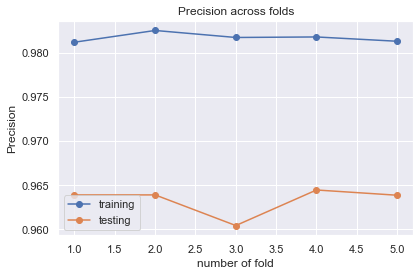

In [9]:
svc_hyp = SVC(C=10, kernel='rbf', gamma=1)

fit_check(svc_hyp, 5)

In [ ]:
svc_hyp_1 = SVC(C=10, kernel='poly', gamma=1 )

fit_check(svc_hyp_1, 5)

###### poly kernel make time even more longer

In [ ]:
svc_hyp_2 = SVC(C=10, kernel='rbf', gamma=10 )

fit_check(svc_hyp_2, 5)

###### gamma parameter in make the training time longer

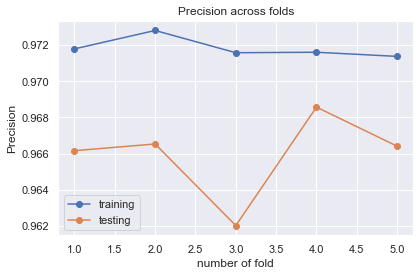

In [9]:
svc_hyp_3 = SVC(C=10, kernel='rbf', gamma='scale')

fit_check(svc_hyp_3, 5)

###### The time for fit_check is 30 minutes long

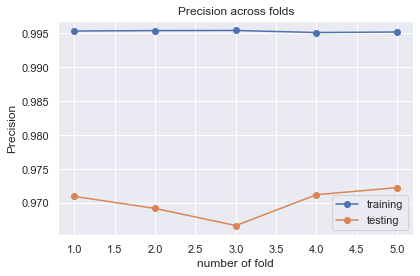

In [10]:
svc_hyp_3 = SVC(gamma=10)

fit_check(svc_hyp_3, 5)

###### The long time for fit_check is 3 hours long

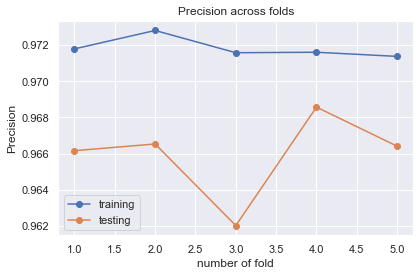

In [13]:
svc_hyp_4 = SVC(C=10)

fit_check(svc_hyp_4, 5)

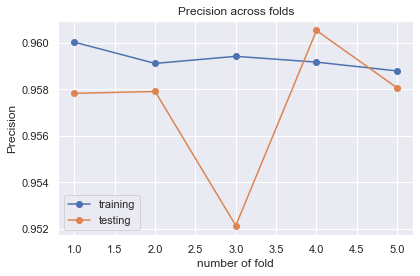

In [14]:
svc_hyp_5 = SVC(C=1)

fit_check(svc_hyp_5, 5)

### Model Conclusion

In [22]:
def model_conclusion(X_train, y_train, X_test, y_test, models):
    
    from sklearn.metrics import precision_score
    
    train_result = []
    test_result = []
    str_models = []
    
    for model in models:
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred = model.predict(X_test)
        precision_train = precision_score(y_train, y_pred_train)
        precision_test = precision_score(y_test, y_pred)       
        train_result.append(precision_train)
        test_result.append(precision_test)  
        str_models.append(str(model))
    
    figsize=(10,10)

    sns.lineplot(str_models, train_result, label='train')
    sns.lineplot(str_models, test_result, label='test')
    plt.ylabel('Precision')
    plt.title('Precision for models')
    plt.xticks(str_models, rotation=90)
    plt.legend()
    plt.tight_layout()
    
    return pd.DataFrame({'models':models, 'precision_train':train_result, 'precission_test':test_result}) 

,models,precision_train,precission_test
0,"(DecisionTreeClassifier(max_features='auto', r...",1.000000,0.970374
1,SVC(),0.960153,0.958689
2,"(DecisionTreeClassifier(criterion='entropy', m...",0.995891,0.971122
3,SVC(C=10),0.971735,0.965722


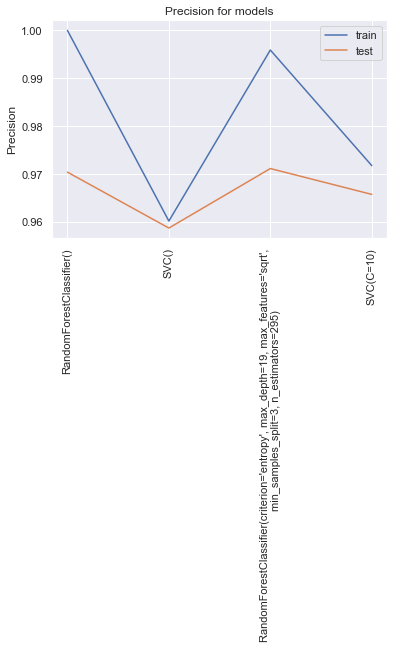

In [25]:
rf = RandomForestClassifier()
svc = SVC()
rf_best = RandomForestClassifier(criterion='entropy', max_depth=19, max_features='sqrt', min_samples_split=3, n_estimators=295)
svc_hype = SVC(C=10)
models = [rf, svc, rf_best, svc_hype]

model_conclusion(X_train, y_train, X_test, y_test, models)

###### from the model conclusion, I choose SVC model after tuning to prevent overfitting with better precision.

### save Machine Learning model

In [26]:
final_model = SVC(C=10)

final_model.fit(X_train, y_train)

SVC(C=10)

In [27]:
import pickle
with open('Airline_Passenger_satisfaction.pickle', 'wb') as f:
    pickle.dump(final_model, f)